In [1]:
from pathlib import Path

import numpy as np
import pandas as pd

In [2]:
data_folder = Path("data")

In [3]:
def parse_experiment_data(file_path):
    """Parses the gain value and Results section data from the given file."""
    results_data = []
    gain_value = None

    with open(file_path, "r") as file:
        lines = file.readlines()
        results_section = False

        for line in lines:
            # Check for Gain value
            if "Gain:" in line:
                gain_value = int(line.split("Gain:")[1].strip())

            # Start parsing the Results section
            if line.startswith("Results"):
                results_section = True
                continue

            # Collect data in Results section
            if results_section:
                # skip the line if it does not contain "Lum"
                if "Lum" not in line:
                    continue
                # Stop if the line doesn't contain data
                if not line.strip():
                    break
                # Exclude non-numeric data (like row headers A, B, etc. and "Lum")
                row_data = [int(value) for value in line.split() if value.isdigit()]
                results_data.extend(row_data)
    
    assert len(results_data) == 96, f"Expected 96 data points, got {len(results_data)}"

    return gain_value, results_data


def parse_folder_data(folder_path):
    """Parses all text files in the specified folder and returns a dictionary with gain values and results data."""
    data_summary = []

    folder_path = Path(folder_path)
    for file_path in folder_path.rglob("*.txt"):
        print(f"Processing file: {file_path}")
        if file_path.suffix == ".txt":  # Process only text files
            gain_value, results_data = parse_experiment_data(file_path)
            data_summary.append({"Gain": gain_value, "Results": results_data})

    return data_summary

In [4]:
raw_calib_data = parse_folder_data(data_folder)

Processing file: data/empty-calib-lumi-SDL_150.txt
Processing file: data/empty-calib-lumi-SDL_180.txt
Processing file: data/empty-calib-lumi-SDL_230.txt
Processing file: data/empty-calib-lumi-SDL_240.txt
Processing file: data/empty-calib-lumi-SDL_190.txt
Processing file: data/empty-calib-lumi-SDL_170.txt
Processing file: data/empty-calib-lumi-SDL_220.txt
Processing file: data/empty-calib-lumi-SDL_160.txt
Processing file: data/empty-calib-lumi-SDL_255.txt
Processing file: data/empty-calib-lumi-SDL_200.txt
Processing file: data/empty-calib-lumi-SDL_210.txt
Processing file: data/empty-calib-lumi-SDL_250.txt


In [5]:
raw_calib_data[0]

{'Gain': 150,
 'Results': [9,
  6,
  3,
  5,
  3,
  3,
  15,
  1,
  3,
  4,
  9,
  3,
  6,
  4,
  4,
  6,
  7,
  3,
  4,
  3,
  4,
  3,
  1,
  6,
  6,
  5,
  9,
  5,
  7,
  2,
  2,
  4,
  5,
  3,
  6,
  1,
  2,
  4,
  8,
  9,
  5,
  2,
  6,
  11,
  2,
  2,
  2,
  8,
  6,
  3,
  3,
  4,
  5,
  7,
  1,
  4,
  3,
  4,
  2,
  4,
  7,
  4,
  3,
  2,
  7,
  5,
  6,
  1,
  5,
  9,
  8,
  7,
  9,
  4,
  3,
  3,
  5,
  2,
  8,
  4,
  6,
  4,
  4,
  6,
  5,
  6,
  10,
  11,
  3,
  4,
  8,
  7,
  2,
  8,
  5,
  1]}

In [6]:
# Create a DataFrame from the parsed data
# each row contains the gain value and the one of the 96 data points
data = []
for entry in raw_calib_data:
    gain_value = entry["Gain"]
    for luminescence_value in entry["Results"]:
        log2_luminescence = np.log2(luminescence_value)
        data.append(
            {
                "gain": gain_value,
                "log2_lum": log2_luminescence,
                "luminescence": luminescence_value,
            }
        )

df = pd.DataFrame(data)

In [7]:
from scipy.stats import norm

def filter_outliers(df):
    """Filters out data points that are more than 3 standard deviations away from the mean for each gain."""
    filtered_data = []

    # Group by gain and fit a normal distribution to log2_lum values in each group
    for gain_value, group in df.groupby("gain"):
        log2_values = group["log2_lum"]
        mean, std = norm.fit(log2_values)  # Fit a normal distribution to get mean and std

        # Filter out values that are more than 3 sigma (3 standard deviations) away from the mean
        within_3_sigma = group[(log2_values >= mean - 3 * std) & (log2_values <= mean + 3 * std)]
        filtered_data.append(within_3_sigma)

    # Concatenate all filtered data back into a DataFrame
    filtered_df = pd.concat(filtered_data, ignore_index=True)
    return filtered_df

In [8]:
df = filter_outliers(df)

Will use the log scale data, since it is more normal distributed, evidence can be found here https://chatgpt.com/share/67311081-c91c-800a-93bd-a3f3424423db

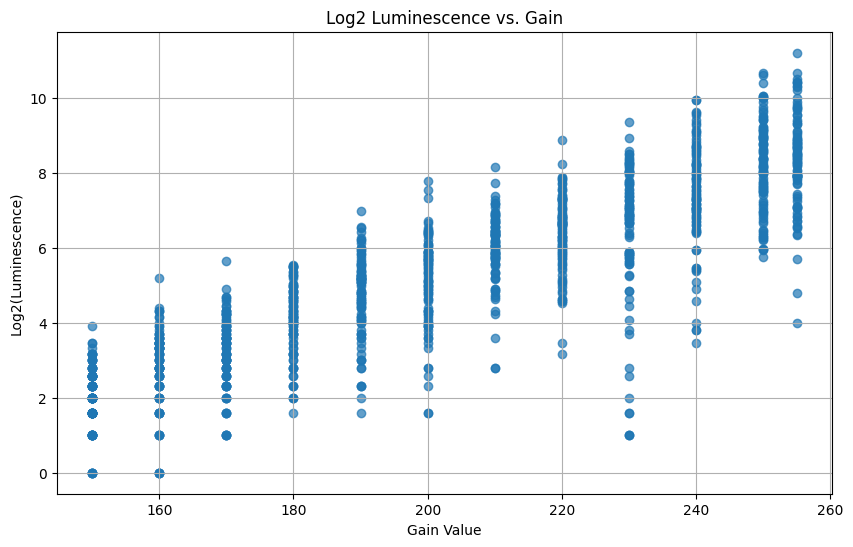

In [9]:
import matplotlib.pyplot as plt

# Example function for plotting parsed data
def plot_log2_luminescence(df):
    """Plots log2 of luminescence values against gain values."""
    plt.figure(figsize=(10, 6))
    plt.scatter(df["gain"], df["log2_lum"], alpha=0.7)
    plt.title("Log2 Luminescence vs. Gain")
    plt.xlabel("Gain Value")
    plt.ylabel("Log2(Luminescence)")
    plt.grid(True)
    plt.show()

# Assuming `df` has been created as described above
plot_log2_luminescence(df)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from sklearn.linear_model import LinearRegression

# Training and saving the regressor
def train_log2_gain_regressor(df):
    """Trains a linear regression model on gain vs. log2(luminescence) data."""
    # Prepare data for regression
    X = df["gain"].values.reshape(-1, 1)
    y = df["log2_lum"].values

    # Train the model
    regressor = LinearRegression()
    regressor.fit(X, y)

    return regressor

def save_regressor_to_json(regressor, file_path="linear_regressor.json"):
    """Saves the linear regression model parameters (slope and intercept) to a JSON file."""
    # Extract parameters from the regressor
    regressor_data = {
        "slope": regressor.coef_[0],
        "intercept": regressor.intercept_
    }

    # Save parameters to JSON
    with open(file_path, "w") as json_file:
        json.dump(regressor_data, json_file)

def load_regressor_from_json(file_path="linear_regressor.json"):
    """Loads the linear regression model from JSON file and returns a simple callable function."""
    with open(file_path, "r") as json_file:
        regressor_data = json.load(json_file)

    # Return a function that calculates y = mx + b
    def regressor_function(gain_value):
        return regressor_data["slope"] * gain_value + regressor_data["intercept"]

    return regressor_function

# Visualization
def plot_regression_with_loaded(df, loaded_regressor_func):
    """Plots the log2(luminescence) data and the linear regression fit using the loaded regressor function."""
    plt.figure(figsize=(10, 6))
    
    # Scatter plot of the original data
    plt.scatter(df["gain"], df["log2_lum"], alpha=0.7, label="Log2(Luminescence) Data")
    
    # Plot regression line using the loaded regressor function
    x_values = np.linspace(df["gain"].min(), df["gain"].max(), 100)
    y_values = [loaded_regressor_func(x) for x in x_values]
    plt.plot(x_values, y_values, color="red", label="Regression Line")
    
    plt.title("Log2 Luminescence vs. Gain with Regression Line (Loaded Regressor)")
    plt.xlabel("Gain Value")
    plt.ylabel("Log2(Luminescence)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [11]:
regressor = train_log2_gain_regressor(df)
save_regressor_to_json(regressor)

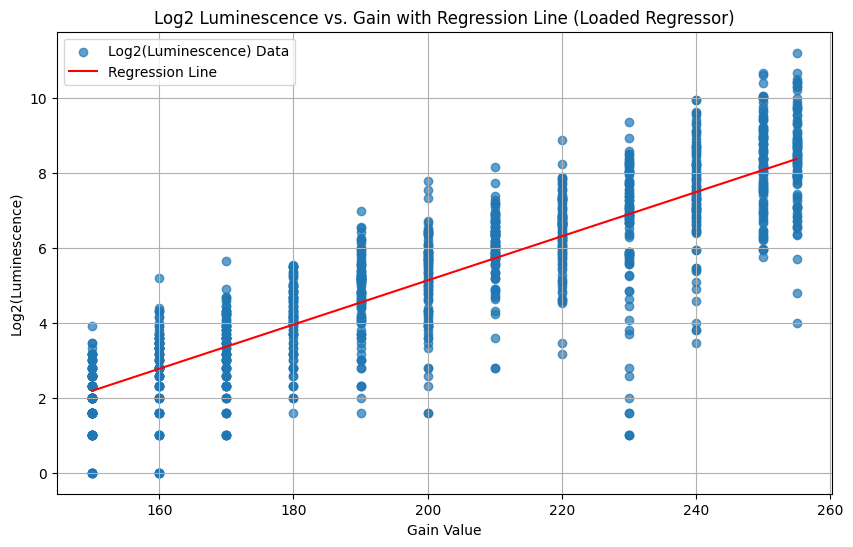

Predicted Log2(Luminescence) for gain 220: 6.316249547647561


In [12]:
loaded_regressor = load_regressor_from_json()
plot_regression_with_loaded(df, loaded_regressor)
predicted_value = loaded_regressor(220)  # Predict for gain value of 220
print(f"Predicted Log2(Luminescence) for gain 220: {predicted_value}")